In [1]:
import pyrealsense2 as rs
import numpy as np
import cv2
import time
from ultralytics import YOLO
#from TCPdepth import closing
#from function_ObjDet  import getObject
#from dimensionYolo import getObjectDimension 
from objectTime import getObjectDimensiont
from robotiq3f_py.robotiqcontrol.GripperController import GripperController
#from yolo11Dimension import getObjectDimensiont
from closing import closing as closeGripper
#from robotiq3f_py.robotiqcontrol.GripperController import GripperController 
#from cam import cama
#from depthTracking import closing
#from depthTracking import gripTrigger

Funktion um Öffnungswinkel an Objektgröße anzupassen

In [ ]:
def openGripper(mode, x):
    m = 1.2987
    b = 255
    # value = x* m +b
    # if value < 0:
    #     value = 0
    # elif value > 77:
    #     value = 77
    if mode == 'Scissor':
        x + 1
        return max(0,min(190,int(-23.75 * x +237.5)))
    else:
        x = x+2
        print(x)
        return max(0,min(90,int(-7 * x +112))) # 90~3cm



Funktion um Werte in Register zu schreiben

In [ ]:
def gripperPos(pos):
    gripperPos = [pos]*3 
    return gripperPos


def gripperSpeed(speed):
    gripperSpeed = [speed]*3 
    return gripperSpeed

def gripperForce(force):
    gripperForce = [force]*3 
    return gripperForce


In [2]:
x = 424
y = 240


dbr = 0.17873      # ausgerechnetes invlaid depth band für abstand von ca 15 cm
xdepth = int(dbr * x)
pipeline = rs.pipeline()
config = rs.config()
filter = rs.decimation_filter()
config.enable_stream(rs.stream.depth, x,y, rs.format.z16, 30)
config.enable_stream(rs.stream.color, x,y, rs.format.bgr8, 30)  # bgr is compatible with OpenCV 
pipelineProfile = pipeline.start(config)

# Align streams
align_to = rs.stream.color
align = rs.align(align_to)


# Set high accuracy mode
depth_sensor = pipelineProfile.get_device().first_depth_sensor()
depth_sensor.set_option(rs.option.visual_preset, rs.rs400_visual_preset.high_accuracy)
#depth_sensor.set_option(rs.option.visual_preset, rs.rs400_visual_preset.medium_density)
depthScale = depth_sensor.get_depth_scale()

RuntimeError: No device connected

Initialize Gripper

In [ ]:
# Initialize the GripperController object with the IP address of the server
try:
    gripper = GripperController("192.168.1.11")
    gripper.activate()
    print('Connected')
except:
    print("No Connection to gripper")
    
'''
ACHTUNG: wird wohl immer verbunden
'''

In [ ]:
#gripper.close()

In [ ]:
while gripper.gIMC != 3:
    print("wait")

In [ ]:
if gripper.gIMC != 0:
    print('okay')

In [ ]:
mode = 'Basic'

target_position = [0]*3
speed = [200] *3
force = [20] * 3
individual_control = False


gripper.command_gripper(rPRA=target_position, rSP=speed, rFR=force, rMOD=mode, rICF=individual_control)
print('command sent')

# for i in range(0,20):
#      time.sleep(0.25)
#      print([gripper.FingerA_Current, gripper.FingerB_Current, gripper.FingerC_Current]) 
#      print(f'position: {gripper.FingerA_Position}')
#      print(f'status_register: {gripper.gSTA}')
      


        # Wait for the gripper to reach the target position or object is detected
# while any([gripper.FingerA_Current, gripper.FingerB_Current, gripper.FingerC_Current]):
#         print('wait')
#         time.sleep(0.1)
while gripper.gSTA == 0:
        print('in Motion')
        
        
print('done')
print(gripper.gSTA)

In [ ]:
value = 0   # daten von Funktion  # Lieber an längste seite anpassen?
force = gripperForce(20)
speed = [255]
target_position = gripperPos(value)

Camera Set-Up

In [ ]:
# pipeline = rs.pipeline()
# config = rs.config()
# config.enable_stream(rs.stream.depth, 424, 240, rs.format.z16, 30)
# config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)  # bgr is compatible with OpenCV
# #pipeline.start(config)
# pipelineProfile = pipeline.start(config)
# # Align Frames to each other
# align_to = rs.stream.color
# align = rs.align(align_to)

# (pipeline)

In [ ]:
# closeGripper = closing(pipeline)
# closeGripper

In [ ]:
#pipeline.stop()
#pipeline.start(config)
#closeGripper = closing(pipeline)


In [ ]:
# depth_sensor = pipelineProfile.get_device().first_depth_sensor()
# # Set high accuracy mode
# depth_sensor = pipelineProfile.get_device().first_depth_sensor() 
# depth_sensor.set_option(rs.option.visual_preset, rs.rs400_visual_preset.high_accuracy)
# depth_scale = depth_sensor.get_depth_scale()

Object Detection

In [ ]:
# confidence_YOLO =0.3
# label, xSize, ySize  = getObjectDimension(confidence_YOLO,pipeline, depthScale, align)

Daten aufnehmen

In [ ]:
Objekte = ['Würrfel', 'Ball', 'Metallplatte', 'Schraubenzieher', 'Schaumstoff Ding']

In [ ]:
Objekt = Objekte[4]
Objekt

'Schaumstoff Ding'

In [21]:
model = YOLO("yolo11n.pt")

for n in range(0,10):
    confidence_YOLO =0.15
    if n > 0:
        confidence_YOLO += 0.05 *n
    for i in range(0,10):
        label, conf, xSize, ySize,elapsedTime, dist  = getObjectDimensiont(model,confidence_YOLO,pipeline, depthScale, align)
        if xSize > ySize:
            maxSide = xSize
            minSide = ySize
        else:
            maxSide = ySize
            minSide = xSize
    
        import csv
        import os

        # Pfad zur CSV-Datei
        csv_datei = "messdatenZeit-Confidence1.1.csv"

        # Daten, die du speichern willst
        daten = [Objekt,label,confidence_YOLO,conf, maxSide, minSide, elapsedTime]

        # Prüfen, ob Datei existiert
        file_exists = os.path.isfile(csv_datei)

        # CSV schreiben (Anhängen oder neu erstellen)
        with open(csv_datei, mode='a', newline='') as file:
            writer = csv.writer(file)

            # Schreibe Kopfzeile, wenn Datei neu
            if not file_exists:
                writer.writerow(['Label','confidence_YOLO', 'confidence', 'xSize [cm]', 'ySize [cm]', 'ElapsedTime [s]'])

            # Schreibe Datenzeile
            writer.writerow(daten)
        print('safed')
        cv2.destroyAllWindows()
print('end')

start Measuring1
*******************************************************************************************************************
Object: knife
Bounding Box size: 38.25 x 6.19
Distance: 0.372
Confidence: 0.462
elapsedTime: 5.296264171600342
*******************************************************************************************************************
[np.float64(38.44458758831024), np.float64(38.28771710395813), np.float64(38.12689334154129), np.float64(37.88170516490936), np.float64(38.34373950958252), np.float64(38.3908674120903)]
[np.float64(6.426124274730682), np.float64(6.461048685014248), np.float64(6.250842288136482), np.float64(6.128276512026787), np.float64(5.897642858326435), np.float64(5.962219834327698)]
safed
start Measuring1
*******************************************************************************************************************
Object: knife
Bounding Box size: 38.17 x 5.51
Distance: 0.367
Confidence: 0.533
elapsedTime: 3.978931427001953
*****************

In [4]:
Objekte = ['Flasche', 'Wasserwaage', 'Kamera Packung', 'Schraubenzieher']

In [5]:
Objekt = Objekte[3]
Objekt

'Schraubenzieher'

In [ ]:
model = YOLO("yolo11n.pt")
confidence_YOLO =0.35
for n in range(0,10):
    
    
        label, conf, xSize, ySize,elapsedTime, dist  = getObjectDimensiont(model,confidence_YOLO,pipeline, depthScale, align)
        if xSize > ySize:
            maxSide = xSize
            minSide = ySize
        else:
            maxSide = ySize
            minSide = xSize
    
        import csv
        import os

        # Pfad zur CSV-Datei
        csv_datei = "Zeiten.csv"

        # Daten, die du speichern willst
        daten = [Objekt,label,confidence_YOLO,conf, maxSide, minSide, elapsedTime]

        # Prüfen, ob Datei existiert
        file_exists = os.path.isfile(csv_datei)

        # CSV schreiben (Anhängen oder neu erstellen)
        with open(csv_datei, mode='a', newline='') as file:
            writer = csv.writer(file)

            # Schreibe Kopfzeile, wenn Datei neu
            if not file_exists:
                writer.writerow(['Label','confidence_YOLO', 'confidence', 'xSize [cm]', 'ySize [cm]', 'ElapsedTime [s]'])

            # Schreibe Datenzeile
            writer.writerow(daten)
        print('safed')
        cv2.destroyAllWindows()
print('end')

start Measuring1
*******************************************************************************************************************
Object: toothbrush
Bounding Box size: 10.67 x 3.23
Distance: 0.262
Confidence: 0.547
elapsedTime: 15.39706563949585
*******************************************************************************************************************
[np.float64(10.792931728065014), np.float64(10.583993047475815), np.float64(10.58399323374033), np.float64(10.665722750127316), np.float64(10.665722750127316), np.float64(10.706588439643383)]
[np.float64(3.193952585570514), np.float64(3.3280496631050482), np.float64(3.242715183296241), np.float64(3.267755324486643), np.float64(3.1817617593333125), np.float64(3.193952585570514)]
safed
start Measuring1
*******************************************************************************************************************
Object: toothbrush
Bounding Box size: 9.79 x 5.97
Distance: 0.252
Confidence: 0.369
elapsedTime: 70.43050241470337


TypeError: 'NoneType' object is not subscriptable

Algorithm for mode

In [26]:
import pandas as pd
import openpyxl
df_new = pd.read_csv('messdaten.csv')
 
# saving xlsx file
GFG = pd.ExcelWriter('Zeit-Messungen.xlsx')
df_new.to_excel(GFG, index=False)

ModuleNotFoundError: No module named 'openpyxl'

In [28]:
import pandas as pd

# CSV-Datei einlesen
df = pd.read_csv("messdaten.csv")

# In Excel-Datei speichern
df.to_excel("messdaten.xlsx", index=False)


In [4]:
if xSize > ySize:
    maxSide = xSize
    minSide = ySize
else:
    maxSide = ySize
    minSide = xSize
    
import csv
import os

# Pfad zur CSV-Datei
csv_datei = "messdaten.csv"

# Daten, die du speichern willst
daten = [label,confidence_YOLO, maxSide, minSide, elapsedTime]

# Prüfen, ob Datei existiert
file_exists = os.path.isfile(csv_datei)

# CSV schreiben (Anhängen oder neu erstellen)
with open(csv_datei, mode='a', newline='') as file:
    writer = csv.writer(file)

    # Schreibe Kopfzeile, wenn Datei neu
    if not file_exists:
        writer.writerow(['Label', 'confidence', 'xSize [cm]', 'ySize [cm]', 'ElapsedTime [s]'])

    # Schreibe Datenzeile
    writer.writerow(daten)


In [ ]:
# objectsWithHole = ["toilet", "donut"]

# if xSize >= 24 or ySize >= 24  :
#     if xSize >= 15 and ySize >= 15:
#         print("Object too big!")
#         mode = None
#     else:
#         mode = "Wide"
# elif xSize >= 12 or ySize >= 12:
#     mode = "Basic"

# elif   (xSize < 3 or ySize < 3) and abs(xSize-ySize) > 2  :
#     mode = "Scissor"
# else:
#     mode = "Pinch"
# #mode = "Basic"
# #mode = "Scissor"
# mode

In [ ]:
# maxSide = 50
# minSide = 50

In [ ]:
objectsWithHole = ["toilet", "donut"]

if maxSide >= 24:
    if minSide >= 15:
        print("Object too big!")
        mode = False
    else:
        mode = "Wide"
elif maxSide >= 12 :
    mode = "Basic"

elif   maxSide < 4 and abs(xSize-ySize) > 2 or minSide <3 :
    mode = "Scissor"
else:
    mode = "Pinch"
mode

Greifer Öfffnung an Objekt anpassen

In [ ]:

if mode:
        value = openGripper(mode,minSide)   # daten von Funktion  # Lieber an längste seite anpassen?
        force = gripperForce(20)
        speed = [255]
        target_position = gripperPos(value)
        
        individual_control = False
        #target_position = [250]*3
        #target_position, force, speed
else:
    individual_control = True
    mode = "Basic"
    target_position = [255,0,0]
    force = gripperForce(20)
    speed = [255]*3
    #target_position = gripperPos(value)
target_position, force, speed, individual_control,mode, minSide	

Commands to get gripper into position

In [ ]:
print(target_position, force, speed, individual_control,mode)

gripper.command_gripper(rPRA=target_position, rSP=speed, rFR=force, rMOD=mode, rICF=individual_control)
print('command sent')

time.sleep(1)
        # Wait for the gripper to reach the target position or object is detected
# while any([gripper.FingerA_Current, gripper.FingerB_Current, gripper.FingerC_Current]):
#         print('wait')
#         time.sleep(0.1)

while gripper.gSTA == 0:
        print('in Motion')

print('end')

commands to close gripper

In [ ]:
grip = False

In [ ]:
grip = closeGripper(pipeline, depthScale, align, mode, x,y)
grip

In [ ]:
grip = True
mode = "Basic"

In [ ]:
if grip:
        target_position = [255]*3 # Closing position
        if mode == "Basic" or mode == "Wide":
                speed = gripperSpeed(0)
        else:
                speed = gripperSpeed(10)
                
        
        gripper.command_gripper(rPRA=target_position, rSP=speed, rFR=force, rMOD=mode, rICF=individual_control)
        print('command sent')              
        # Wait for the gripper to reach the target position or object is detected
        # while any([gripper.FingerA_Current, gripper.FingerB_Current, gripper.FingerC_Current]):
        #         print('wait')
        #         time.sleep(0.1)
        while gripper.gSTA == 0:
                print(gripper.FingerA_Current)
        
        print('end')

In [ ]:
#gripper.close()
pipeline.stop()

# END

In [ ]:

target_position= [0]*3
gripper.command_gripper(rPRA=target_position, rSP=speed, rFR=force, rMOD=mode, rICF=individual_control)
print('command sent')

        # Wait for the gripper to reach the target position or object is detected
while any([gripper.FingerA_Current, gripper.FingerB_Current, gripper.FingerC_Current]):
        print('wait')
        time.sleep(0.1)

print('end')

#### Send commands

In [ ]:
gripper.close()

### Close gripper

#### Requirement for closing the gripper

In [ ]:
'''
Nicht aus Kamera ausbrechen, sondern drin bleiben und ditanz überpfüfen

Wenn kleiner als bestimmter Wert greifer Schlißen
'''


In [ ]:
#pipelineProfile = pipeline.start(config)
device = pipelineProfile.get_device()
depthSensor = device.first_depth_sensor()
if depthSensor:
    depthSensor.set_option(rs.option.visual_preset, rs.rs400_visual_preset.high_accuracy)
    print('High Accuracy activated')

In [ ]:
# b = 

#### Values to close Gripper

In [ ]:
closeGripper = True

#### Send commands

# Wait for next instruction

In [ ]:
print("Ready for next Step")

# Open Gripper to give Object

In [ ]:
'''
Mit mediapipe hand landmarks checken und wenn an Gripper dann loslassen 
Oder wenn Widerstand gespürt wird?
'''

Versuche


In [ ]:
pipeline.stop() 
gripper.close()

In [ ]:
target_position = [0]*3 # Closing position
movement = [300]*3
gripper.command_gripper(rPRA=target_position, rSP=speed, rFR=force, rMOD=mode, rICF=individual_control)
print('command sent')
movement.append([gripper.FingerA_Position, gripper.FingerB_Position, gripper.FingerC_Position])
i = 1

        # Wait for the gripper to reach the target positions
while ([gripper.FingerA_Position, gripper.FingerB_Position, gripper.FingerC_Position] != target_position):
       # while any([gripper.FingerA_Current, gripper.FingerB_Current, gripper.FingerC_Current]) !=0: #probleme mit zugreifen, da bei objekterkennung automatisch gestoppt wird?
        # while()
        # If no futher movemnt because of object in hand -> stop moving!
        fingerPos = [gripper.FingerA_Position, gripper.FingerB_Position, gripper.FingerC_Position]
        movement[i] = fingerPos
        print('checking')
        if fingerPos == movement[i-1]:
                movement.append(fingerPos)
        if len(movement):
                break
                
        else: 
                movement[0] = [300]*0
        print([gripper.FingerA_Position, gripper.FingerB_Position, gripper.FingerC_Position])
        print('Sleep')
        time.sleep(0.1)
print('end')

In [ ]:
# Get Data for model
a = getObject(pipeline)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
x = [16, 13, 9, 6]
y = [0, 26, 51, 77]
px = ySize
py = openGripper(ySize) 
plt.scatter(px, py, marker='x', s=100, color='red', label="Punkt (px, py)")
plt.plot(x,y)
plt.grid()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# x-Werte von 0 bis 18
x_values = np.linspace(0, 18, 100)

# Funktion als lineare Gleichung
y_values = np.clip(x_values * 77 / -9.5 + 129, 0, 77)  # Clipping zwischen 0 und 77

# Plot erstellen
plt.plot(x_values, y_values, label="f(x) = max(0, min(77, x * 77 / -9.5 + 129))", color='blue')
px = ySize
py = openGripper(ySize) 
plt.scatter(px, py, marker='x', s=100, color='red', label="Punkt (px, py)")
# Achsenbeschriftungen
plt.xlabel("x-Werte")
plt.ylabel("f(x)")
plt.title("Lineare Funktion f(x)")

# Gitter aktivieren
plt.grid(True)
plt.legend()

# Plot anzeigen
plt.show()


In [ ]:
def transform(x):
    return -(8.1) * x + 129

x_values = [16, 15.5, 15, 14.5, 14, 13.5, 13, 12.5, 12, 11.5, 11, 10.5, 10, 9.5, 9, 8.5, 8, 7.5, 7, 6.5, 0]
y_values = [transform(x) for x in x_values]

for x, y in zip(x_values, y_values):
    print(f"x: {x}, y: {y:.8f}")


In [ ]:
13*(-8.1) + 129

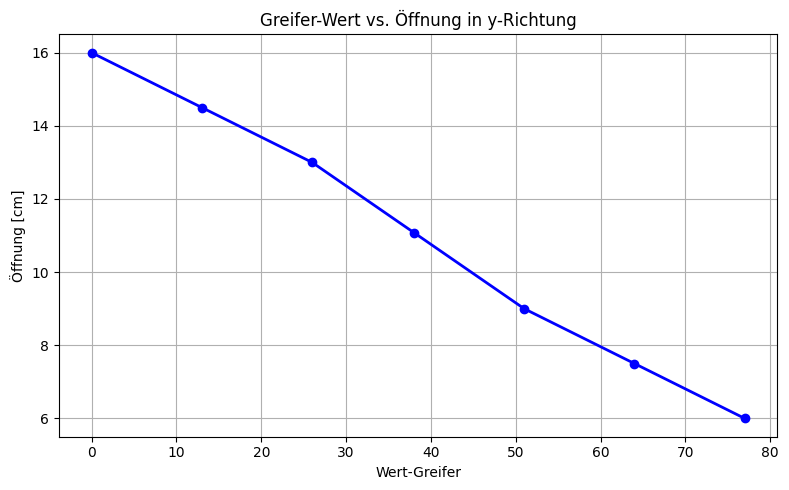

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Originaldaten aus deiner Tabelle
greifer_werte = [0, 13, 26, 38, 51, 64, 77]
# Nur an bestimmten Punkten ist die Öffnung bekannt
# Die restlichen werden interpoliert
oeffnung_bekannt = {
    0: 16,
    26: 13,
    51: 9,
    77: 6
}

# Werte für Interpolation extrahieren
x_known = list(oeffnung_bekannt.keys())
y_known = list(oeffnung_bekannt.values())

# Alle Öffnungswerte berechnen durch lineare Interpolation
oeffnung_cm_interp = np.interp(greifer_werte, x_known, y_known)

# Plot erstellen
plt.figure(figsize=(8, 5))
plt.plot(greifer_werte, oeffnung_cm_interp, marker='o', color='blue', linewidth=2)
plt.title("Greifer-Wert vs. Öffnung in y-Richtung")
plt.xlabel("Wert-Greifer")
plt.ylabel("Öffnung [cm]")
plt.grid(True)
plt.tight_layout()
plt.show()


Validierung